In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 729 kB 5.4 MB/s 
     |████████████████████████████████| 251 kB 44.9 MB/s 


In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

import matplotlib.pyplot as plt

In [3]:
# Para hacerlo reproducible
set_determinism(seed=0)

In [4]:
# Descargamos los datos
root_dir = tempfile.mkdtemp()
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [01:11, 22.6MB/s]                            

2022-02-04 13:24:30,243 - INFO - Downloaded: /tmp/tmp57z9xtcw/Task09_Spleen.tar


2022-02-04 13:24:33,869 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2022-02-04 13:24:33,870 - INFO - Writing into directory: /tmp/tmp57z9xtcw.


In [5]:
# Buscamos los datos descargados y separamos para crear los conjuntos de train y test
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, test_files = data_dicts[:-9], data_dicts[-9:]

In [6]:
# Misma estructura que PyTorch en las prácticas.
# Constants definition. 
batch_size = 2
epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_transforms = Compose([
  LoadImaged(keys=["image", "label"]),
  EnsureChannelFirstd(keys=["image", "label"]),
  Spacingd(keys=["image", "label"], pixdim=(
      1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
  Orientationd(keys=["image", "label"], axcodes="RAS"),
  ScaleIntensityRanged(
      keys=["image"], a_min=-57, a_max=164,
      b_min=0.0, b_max=1.0, clip=True,
  ),
  CropForegroundd(keys=["image", "label"], source_key="image"),
  RandCropByPosNegLabeld(
      keys=["image", "label"],
      label_key="label",
      spatial_size=(96, 96, 96),
      pos=1,
      neg=1,
      num_samples=4,
      image_key="image",
      image_threshold=0,
  ),
  EnsureTyped(keys=["image", "label"]),
])

train_dataset = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_transforms = Compose([
  LoadImaged(keys=["image", "label"]),
  EnsureChannelFirstd(keys=["image", "label"]),
  Spacingd(keys=["image", "label"], pixdim=(
      1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
  Orientationd(keys=["image", "label"], axcodes="RAS"),
  ScaleIntensityRanged(
      keys=["image"], a_min=-57, a_max=164,
      b_min=0.0, b_max=1.0, clip=True,
  ),
  CropForegroundd(keys=["image", "label"], source_key="image"),
  EnsureTyped(keys=["image", "label"]),
])

test_dataset = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 9/9 [00:21<00:00,  2.44s/it]


In [7]:
# Statistics printing
for data in train_loader:
  x_batch = data['image']
  y_batch = data['label']
  break
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))

for data in test_loader:
  x_batch = data['image']
  y_batch = data['label']
  break
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))
print("Example batch shape: {}".format(x_batch.shape))
# Al ser segmentación 3D, cno es necesario tener una gran cantidad de muestras (al menos en esta categoría de aplicaciones)

Training set: 32 samples - Max value: 1.0 - Min value: 0.0
Test set: 9 samples - Max value: 1.0 - Min value: 0.0
Example batch shape: torch.Size([1, 1, 226, 157, 113])


image shape: torch.Size([226, 157, 113]), label shape: torch.Size([226, 157, 113])


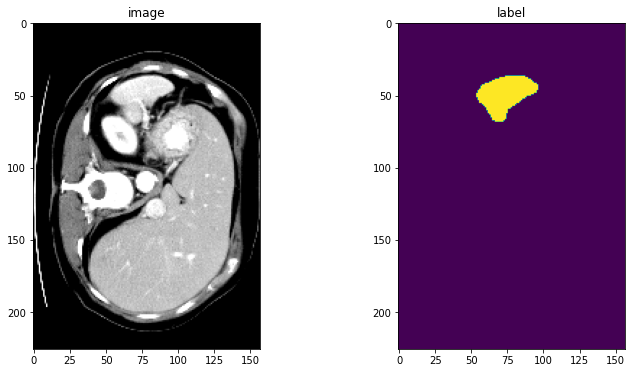

In [8]:
# OPCIONAL --> Echamos un vistazo a una imagen y cómo es su segmentación 
check_dataset = Dataset(data=test_files, transform=test_transforms)
check_loader = DataLoader(check_dataset, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [9]:
# Instantiating the network and printing its architecture
net = UNet(
    spatial_dims=3, # segmentación de 3 dimensiones
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2), # Longitud channels -1 
    num_res_units=2, # nº de unidades residuales
    norm=Norm.BATCH,
).to(device)
print(net)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [10]:
# Training hyperparameters
criterion = DiceLoss(to_onehot_y=True, softmax=True) # Criterio para segmentación
#optimizer = torch.optim.Adam(net.parameters(), 1e-4)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [11]:
# Learning Rate Annealing (LRA) scheduling
# lr = 0.1     if epoch < 50
# lr = 0.01    if 50 <= epoch < 100
# lr = 0.001   if epoch >= 100
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5) # factor 0.1 de serie. Lo usaremos sobre dice ('accuracy') por lo que maximizaremos

In [ ]:
best_metric = -1
train_loss_values = []
metric_values = []
# Para cálculo de Dice
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])
print("\n---- Start Training ----")
for epoch in range(epochs):
  # TRAIN THE NETWORK
    net.train()
    train_loss = 0
    for batch_data in train_loader:
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # Cálculo del loss, como hasta ahora
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)/2
    train_loss_values.append(train_loss)
   # TEST NETWORK
    net.eval()
    with torch.no_grad():
      for test_data in test_loader:
            inputs, labels = (
                test_data["image"].to(device),
                test_data["label"].to(device),
            )
            roi_size = (160, 160, 160) # regions of interest
            metric_outputs = sliding_window_inference(
                inputs, roi_size, 4, net)
            metric_outputs = [post_pred(i) for i in decollate_batch(metric_outputs)]
            metric_labels = [post_label(i) for i in decollate_batch(labels)]
            # En lugar de loss, calculamos la métrica (mean dice) por lo que se han transformado outputs y targets para obtenerlo
            dice_metric(y_pred=metric_outputs, y=metric_labels)
      metric = 100. * dice_metric.aggregate().item()
      # reset the status for next validation round
      dice_metric.reset()

      metric_values.append(metric)
      if metric > best_metric:
        best_metric = metric
        torch.save(net.state_dict(), os.path.join(
            root_dir, "best_metric_model.pth"))
       # Get current learning rate via the optimizer
      for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
      print(f"[Epoch {epoch + 1}] with LR: {current_lr:.5f} - Average train loss: {train_loss:.4f} - Test mean dice: {metric:.2f}%")
      scheduler.step() # en caso de usar scheduler por escalones fijos
      #scheduler.step(metric) # si usamos plateau como lr scheduler
print('Finished Training')
print("Best Test accuracy: {:.2f}".format(best_metric))


---- Start Training ----
[Epoch 1] with LR: 0.10000 - Average train loss: 0.5634 - Test mean dice: 4.02%
[Epoch 2] with LR: 0.10000 - Average train loss: 0.4728 - Test mean dice: 9.68%
[Epoch 3] with LR: 0.10000 - Average train loss: 0.4302 - Test mean dice: 12.44%
[Epoch 4] with LR: 0.10000 - Average train loss: 0.3311 - Test mean dice: 26.53%
[Epoch 5] with LR: 0.10000 - Average train loss: 0.2813 - Test mean dice: 5.27%
[Epoch 6] with LR: 0.10000 - Average train loss: 0.3217 - Test mean dice: 42.20%
[Epoch 7] with LR: 0.10000 - Average train loss: 0.3056 - Test mean dice: 60.52%
[Epoch 8] with LR: 0.10000 - Average train loss: 0.2825 - Test mean dice: 7.75%
[Epoch 9] with LR: 0.10000 - Average train loss: 0.2609 - Test mean dice: 51.16%
[Epoch 10] with LR: 0.10000 - Average train loss: 0.2441 - Test mean dice: 56.05%
[Epoch 11] with LR: 0.10000 - Average train loss: 0.2578 - Test mean dice: 45.78%
[Epoch 12] with LR: 0.10000 - Average train loss: 0.2352 - Test mean dice: 34.83%
[Ep

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(train_loss_values)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(metric_values)
plt.show()

In [ ]:
net.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
net.eval()
with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        roi_size = (160, 160, 160)
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, batch_size, net
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

In [ ]:
if root_dir is None:
    shutil.rmtree(root_dir)